<a href="https://colab.research.google.com/github/Tasneem1028/CV-DL/blob/main/Skin_Lesion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#step 1: load the dataset

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import top_k_categorical_accuracy


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# data_dir="/content/drive/MyDrive/all images"
# dest_dir="/content/reorganised"

In [ ]:
#read metadata
skin_df=pd.read_csv('HAM10000_metadata.csv')
print(skin_df.head())


In [ ]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))


C:\Users\parve\AppData\Local\Temp\ipykernel_113160\3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


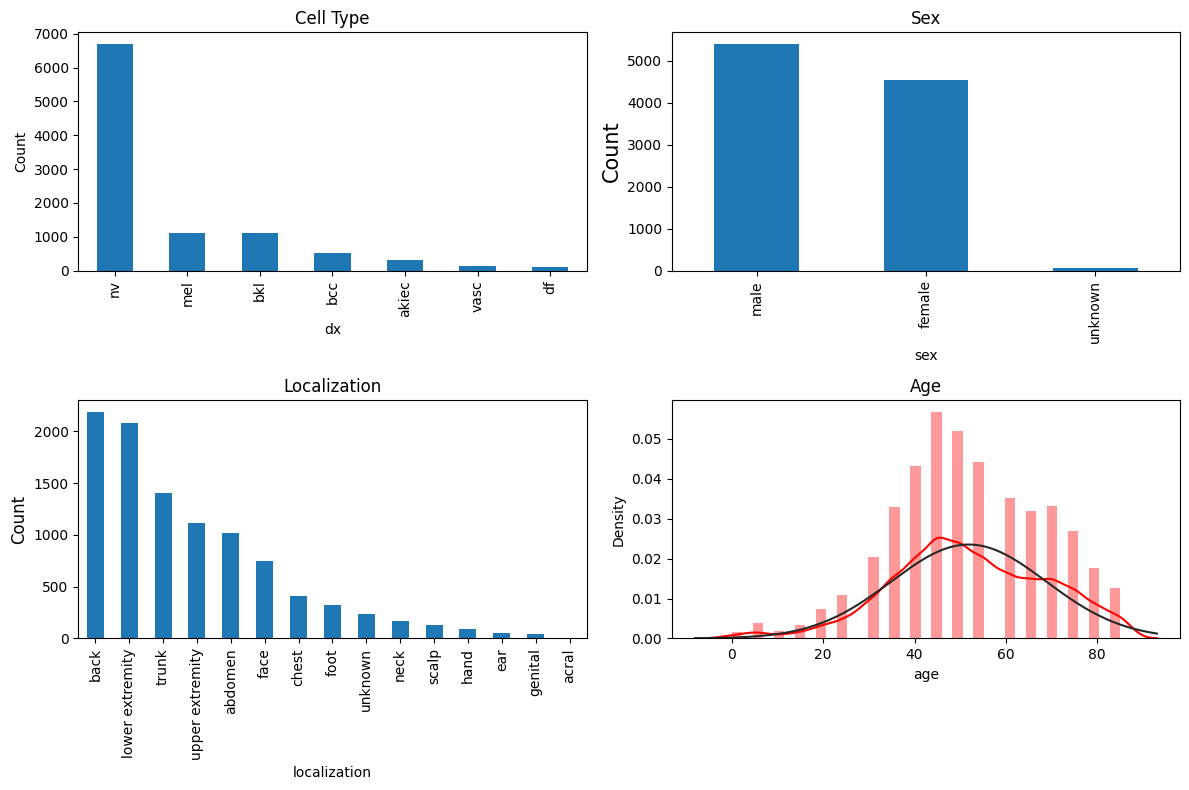

In [12]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [11]:
# Distribution of data into various classes
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [13]:
#Balance data.
#Separate each classes, resample, and combine back into single dataframe
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])




In [14]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [ ]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
# x='/content/drive/MyDrive/all images/ISIC_0024306.jpg'
# image_path = {os.path.basename(x): x for x in glob(os.path.join('/content/drive/MyDrive/all images/', '*.jpg'))}
# #x='/content/drive/MyDrive/all images/ISIC_0024306.jpg'
# file = os.path.splitext(str(os.path.basename(x)).split('.')[0])
# file_name=file[0]

# print(file_name)

In [ ]:
#Define the path and add as a new column
# skin_df['image_id']=skin_df['image_id']+'.jpg'
# skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)


In [15]:


# ✅ Define paths for both image folders
image_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']

# ✅ Collect all image file paths from both folders
image_path = {}
for folder in image_folders:
    for path in glob(os.path.join(folder, '*.jpg')):
        image_path[os.path.basename(path)] = path

# ✅ Add '.jpg' to image_id and map to actual paths
skin_df['image_id'] = skin_df['image_id'] + '.jpg'
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

# ✅ Quick checks
print("Total images found:", len(image_path))
print(skin_df_balanced.sample(3))
print(skin_df['label'].head())
print(skin_df['dx'].head())


Total images found: 10015
        lesion_id      image_id     dx dx_type   age     sex     localization  \
2379  HAM_0001852  ISIC_0033749   vasc   histo  80.0    male  lower extremity   
9919  HAM_0006442  ISIC_0033000  akiec   histo  70.0    male             hand   
2347  HAM_0007614  ISIC_0027672   vasc   histo  55.0  female             face   

      label                                     path  
2379      6  HAM10000_images_part_2\ISIC_0033749.jpg  
9919      0  HAM10000_images_part_2\ISIC_0033000.jpg  
2347      6  HAM10000_images_part_1\ISIC_0027672.jpg  
0    2
1    2
2    2
3    2
4    2
Name: label, dtype: int64
0    bkl
1    bkl
2    bkl
3    bkl
4    bkl
Name: dx, dtype: object


In [ ]:
# print(image_path)
# print(skin_df_balanced.sample(3))
# print(skin_df['label'])
# print(skin_df['dx'])

In [ ]:
#SKIN_DF_BALANCED HAS PATH COLOUMN AND SKIN_DF HAS IMAGE ID WITH .JPG

In [16]:
#Use the path to read images.
SIZE=32
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [17]:
print(skin_df_balanced.sample(3))

        lesion_id      image_id     dx dx_type   age   sex localization  \
9837  HAM_0003262  ISIC_0026212  akiec   histo  45.0  male         face   
94    HAM_0004852  ISIC_0030565    bkl   histo  65.0  male         face   
9928  HAM_0006560  ISIC_0028063  akiec   histo  50.0  male         face   

      label                                     path  \
9837      0  HAM10000_images_part_1\ISIC_0026212.jpg   
94        2  HAM10000_images_part_2\ISIC_0030565.jpg   
9928      0  HAM10000_images_part_1\ISIC_0028063.jpg   

                                                  image  
9837  [[[190, 128, 142], [194, 129, 147], [200, 141,...  
94    [[[165, 124, 138], [168, 133, 151], [167, 127,...  
9928  [[[218, 127, 138], [220, 125, 138], [221, 130,...  


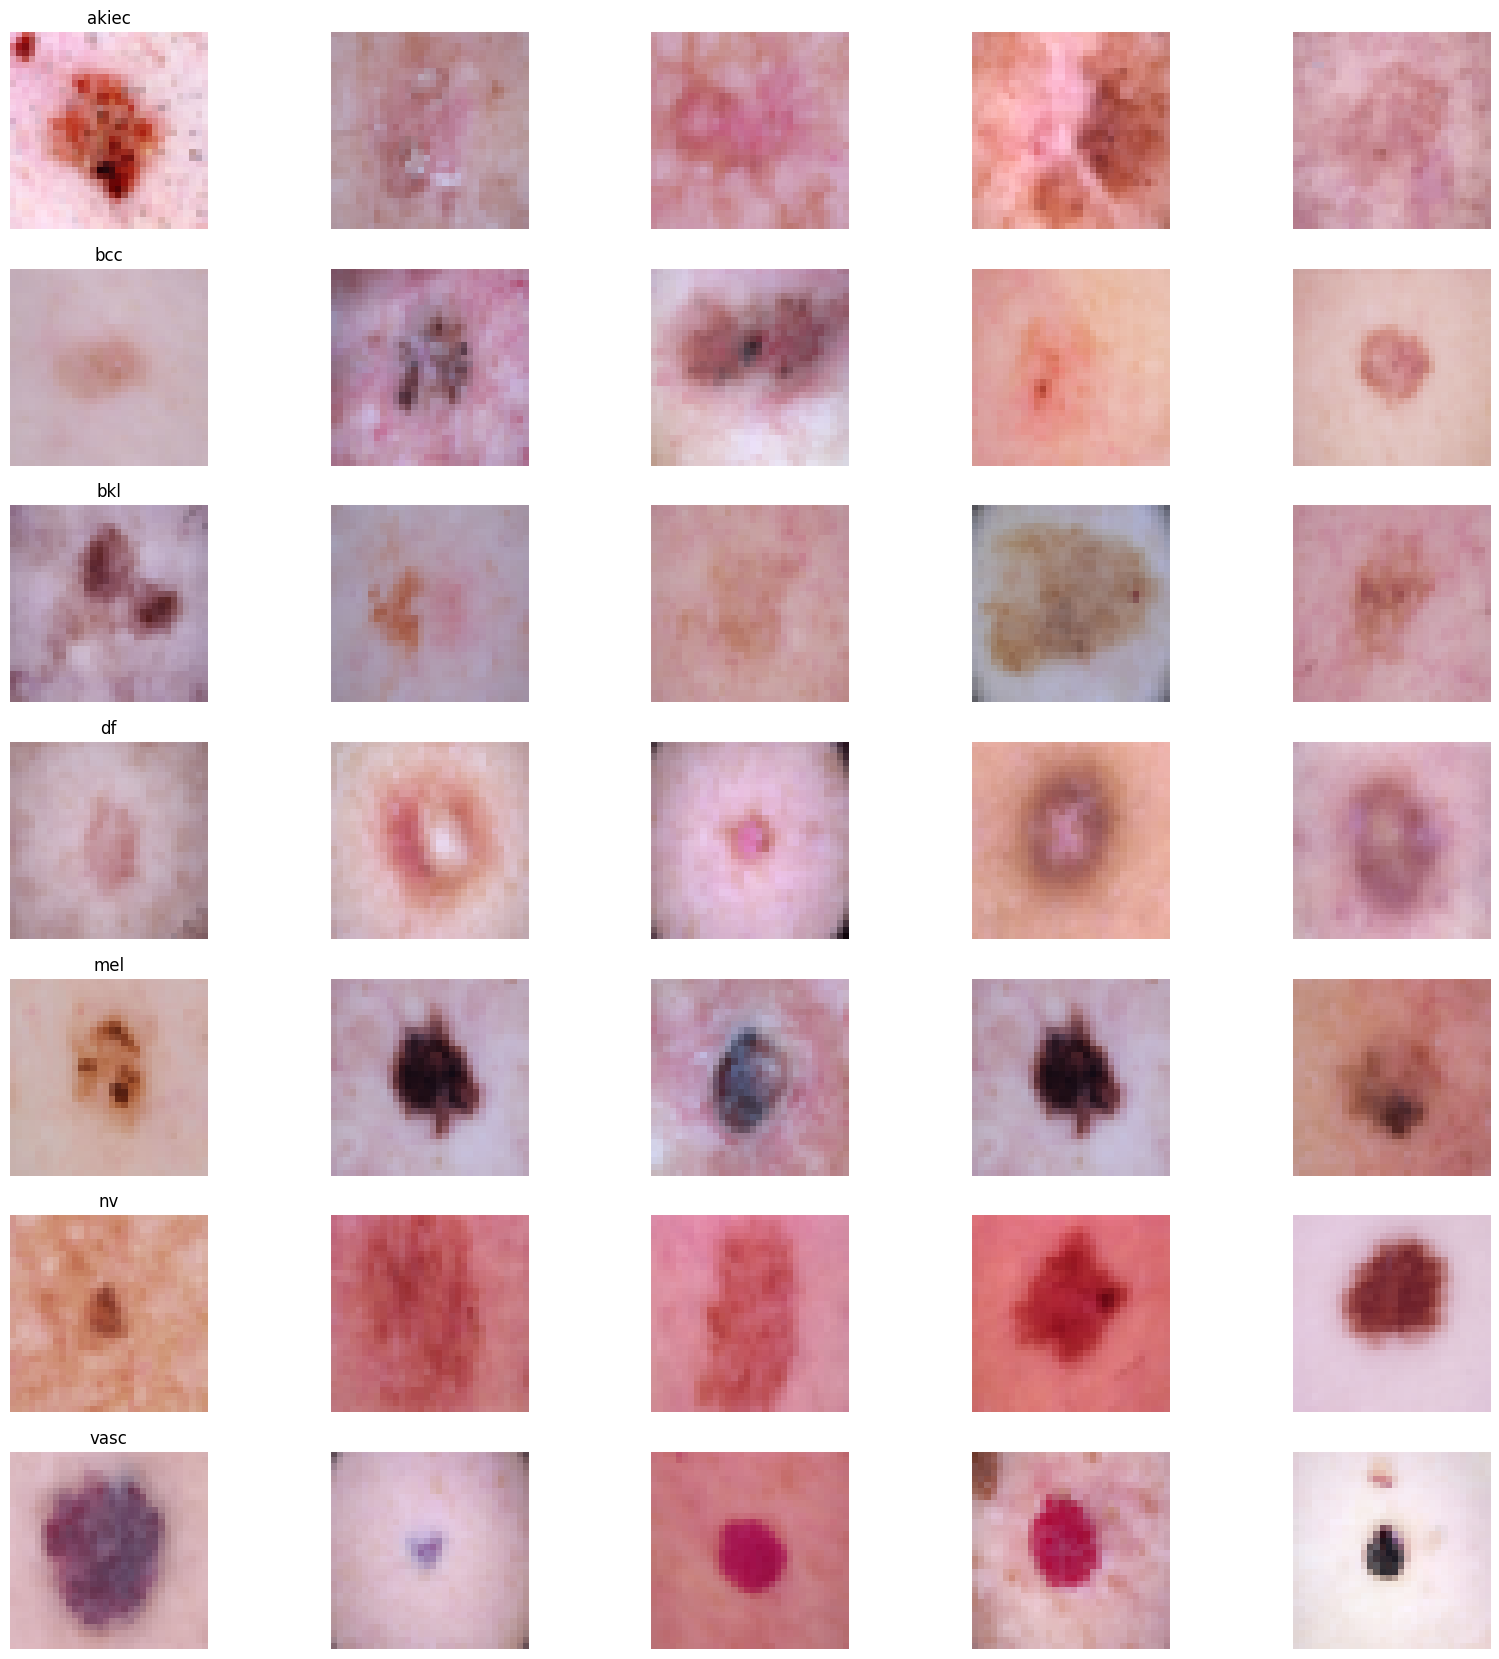

In [18]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [19]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)



In [20]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
#AUGMNENTATION

In [21]:
X = X / 255.  # Scale values to 0-1. You can also use standardscaler or other scaling methods.
Y = skin_df_balanced['label']  # Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7)  # Convert to categorical as this is a multiclass classification problem


In [22]:
# Define the MobileNet-based model
image_size = 32
num_classes = 7

base_model = MobileNet(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
x = base_model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers except the last 23 layers for training
for layer in model.layers[:-23]:
    layer.trainable = False

# Custom accuracy metrics
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Compile the model
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['categorical_accuracy', top_2_accuracy, top_3_accuracy])

# Class weights
class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.7,
    5: 1.0,
    6: 1.0,
}
#{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
'''Melanocytic nevi (nv)
Benign Keratosis (bkl)
Dermatofibroma (df)
Actinic Keratosis (akiec)
vasculaer lesion(vas)
Melanoma (mel)
Basal Cell Carcinoma (bcc)
'''
# Checkpoint and learning rate reduction callbacks
filepath = "/content/drive/MyDrive/models.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.55, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]
# Train the model
batch_size = 32
epochs = 37

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=(x_test, y_test),
    validation_steps=len(x_test) // batch_size,
    class_weight=class_weights,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1
)

# Evaluate the model using the validation set
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate(x_test, y_test)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

C:\Users\parve\AppData\Local\Temp\ipykernel_113160\592532686.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step 


ValueError: Argument(s) not recognized: {'lr': 0.01}

In [ ]:
#testing
# Load the saved model
model.save("/content/drive/MyDrive/models.h5")


# Step 3: Preprocess the test data
x_test_preprocessed = datagen.standardize(x_test)

# Step 4: Make predictions
predictions = model.predict(x_test_preprocessed)

# Step 5: Evaluate the model
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc = model.evaluate(x_test_preprocessed, y_test)

print('Test loss:', test_loss)
print('Test categorical accuracy:', test_cat_acc)
print('Test top-2 accuracy:', test_top_2_acc)
print('Test top-3 accuracy:', test_top_3_acc)



In [ ]:
image_path = str(input("image for testing: ")) # path to your image

In [ ]:


def preprocess_image(image_path, target_size=(32, 32)):
    # Load the image and resize it to the target size
    image = Image.open(image_path)
    image = image.resize(target_size)

    # Preprocess the image
    image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    return image_array

def classify_image(image_path, model):
    # Preprocess the image
    image_array = preprocess_image(image_path)

    # Make prediction
    predictions = model.predict(image_array)

    # Get the predicted label
    predicted_label = np.argmax(predictions)

    return predicted_label

# Define the custom metric functions
def top_2_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

# Load the model
model = load_model("/content/drive/MyDrive/models.h5", custom_objects={"top_2_accuracy": top_2_accuracy, "top_3_accuracy": top_3_accuracy})


predicted_label = classify_image(image_path, model)

print("Predicted label:", predicted_label)


In [ ]:
label_to_dx_mapping = skin_df_balanced[['label', 'dx']].drop_duplicates().sort_values('label').set_index('label')['dx'].to_dict()

# Print the mapping
print(label_to_dx_mapping)